## Business Problem

If you are new to reddit and have never used it before, you might be initimated by the number of subreddits that are present in this online community. 

Furthermore, if you have a question as a system administrator or a network administrator, which subreddit do you pose your question in? https://www.reddit.com/r/sysadmin/ or https://www.reddit.com/r/networking/? With IT teams using these two role names interchangeably and with organizations increasingly expecting their staff to wear multiple hats, there is not a clear demarcation to what constitutes a network or system issue. The issue might even be multi-faceted that requires domain knowledge of both areas of expertise. 


This projects aims to create a machine learning model to be able to review posts and show which subreddit it would belong to and thus increase your probability of getting a helpful response to your issue. 

---

## Table of Contents

1. [Data Cleaning](#Data_Cleaning)
2. [Merging the two subreddits](#Data_Merging)
3. [Train/Test Split](#Train_Test_Split)
4. [Stopwords](#Stopwords)
5. [Preprocessing](#Preprocessing)



In [1]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import re

/Users/johnsmith/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#setting some defaults to display 
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500
pd.options.display.max_info_rows = 500
pd.options.display.max_info_columns = 500

<a id = "Data_Cleaning"></a>

## Data Cleaning

In the process of webscaping from the subreddits, we found that different subpages of the URL gave different number of columns that were not found in the other subpages. We got around this by saving our data into two separate CSVs for each subreddit. The process below involves removing the duplicated posts that came from the webscape and the removal of the column headings that followed every write to CSV. The end results is a csv of the total number of unique posts we were able to extract from reddit. 

In [3]:
networking_df = pd.read_csv('../datasets/networking.csv')
networking_df.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video
0,NaN,networking,"Hi All,\nIn order to stem off a flood of quest...",t2_rm62wli,False,NaN,0,False,COVID-19 Superthread: Discuss your BCP/VPN que...,[],r/networking,False,6,NaN,0,False,t3_fh6989,False,dark,0.92,NaN,public,191,0,{},69d38852-ff47-11e0-8dbe-12313d192a33,False,[],NaN,False,False,NaN,{},NaN,False,191,NaN,False,NaN,1583968932.0,NaN,[],{},NaN,True,NaN,1583996670.0,text,6,NaN,NaN,text,self.networking,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,False,False,False,Moderator | Sr. Network Diplomat,[],False,NaN,NaN,moderator,t5_2qkaf,NaN,NaN,NaN,fh6989,True,NaN,OhMyInternetPolitics,NaN,257,False,all_ads,False,[],False,dark,/r/networking/comments/fh6989/covid19_superthr...,all_ads,True,https://www.reddit.com/r/networking/comments/f...,204818,1583967870.0,1,NaN,False
1,NaN,networking,It's Wednesday! Time to get that crap that's b...,t2_6l4z3,False,NaN,0,False,Rant Wednesday!,[],r/networking,False,6,NaN,0,False,t3_ginoe8,False,dark,0.68,NaN,public,5,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,5,NaN,True,NaN,False,NaN,[],{},NaN,True,NaN,1589357047.0,text,6,NaN,NaN,text,self.networking,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,True,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,moderator,t5_2qkaf,NaN,NaN,NaN,ginoe8,True,NaN,AutoModerator,NaN,14,False,all_ads,False,[],False,NaN,/r/networking/comments/ginoe8/rant_wednesday/,all_ads,True,https://www.reddit.com/r/networking/comments/g...,204818,1589328247.0,0,NaN,False
2,NaN,networking,"Hi all,\n\nSo I've just started a new role whe...",t2_14ishx,False,NaN,0,False,Visio alternative for Network diagrams,[],r/networking,False,6,NaN,0,False,t3_gj88ul,False,dark,0.9,NaN,public,83,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,83,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1589434204.0,text,6,NaN,NaN,text,self.networking,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2qkaf,NaN,NaN,NaN,gj88ul,True,NaN,lancejack2,NaN,71,True,all_ads,False,[],False,NaN,/r/networking/comments/gj88ul/visio_alternativ...,all_ads,False,https://www.reddit.com/r/networking/comments/g...,204818,1589405404.0,0,NaN,False
3,NaN,networking,I could use a brain check/fresh minds on this....,t2_4d30h,False,NaN,0,False,Cisco ASA to Sonicwall VPN - can't get the Cis...,[],r/networking,False,6,NaN,0,False,t3_gjdubc,False,dark,1.0,NaN,public,6,0,{},46699a82-fef7-11e0-81b7-12313d18ad57,False,[],NaN,False,False,NaN,{},NaN,False,6,NaN,False,NaN,1589425831.0,NaN,[],{},NaN

In [4]:
#reading in our second csv file for networking subreddit
networking_m_df = pd.read_csv('../datasets/networking_m.csv')
networking_m_df.head()

/Users/johnsmith/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (101,102,103) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,author_cakeday,crosspost_parent_list,crosspost_parent
0,NaN,networking,So I have a situation where I'd like to contro...,t2_6iwnl,False,NaN,0,False,PBR based on BGP communities?,[],r/networking,False,6,NaN,0,False,t3_gjffvu,False,dark,0.6,NaN,public,1,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,1,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1589460008.0,text,6,NaN,NaN,text,self.networking,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,True,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2qkaf,NaN,NaN,NaN,gjffvu,True,NaN,ljb2of3,NaN,2,True,all_ads,False,[],False,NaN,/r/networking/comments/gjffvu/pbr_based_on_bgp...,all_ads,False,https://www.reddit.com/r/networking/comments/g...,204819,1589431208.0,0,NaN,False,NaN,NaN,NaN
1,NaN,networking,I live in a rural area in Canada where the onl...,t2_ghmww,False,NaN,0,False,Rural internet standard,[],r/networking,False,6,NaN,0,False,t3_gjex4t,False,dark,0.5,NaN,public,0,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,0,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1589457794.0,text,6,NaN,NaN,text,self.networking,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,True,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2qkaf,NaN,NaN,NaN,gjex4t,True,NaN,mwason,NaN,3,True,all_ads,False,[],False,NaN,/r/networking/comments/gjex4t/rural_internet_s...,all_ads,False,https://www.reddit.com/r/networking/comments/g...,204819,1589428994.0,0,NaN,False,NaN,NaN,NaN
2,NaN,networking,I could use a brain check/fresh minds on this....,t2_4d30h,False,NaN,0,False,Cisco ASA to Sonicwall VPN - can't get the Cis...,[],r/networking,False,6,NaN,0,False,t3_gjdubc,False,dark,1.0,NaN,public,7,0,{},46699a82-fef7-11e0-81b7-12313d18ad57,False,[],NaN,False,False,NaN,{},NaN,False,7,NaN,False,NaN,1589425831.0,NaN,[],{},NaN,True,NaN,1589453491.0,text,6,NaN,NaN,text,self.networking,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,False,False,False,CCNA,[],False,NaN,NaN,NaN,t5_2qkaf,NaN,NaN,NaN,gjdubc,True,NaN,overmonk,NaN,4,True,all_ads,False,[],False,dark,/r/networking/comments/gjdubc/cisco_asa_to_son...,all_ads,False,https://www.reddit.com/r/networking/comments/g...,204819,1589424691.0,0,NaN,False,NaN,NaN,NaN
3,NaN,networking,I’m just curious on the difficulty of installi...,t2_13txv4,False,NaN,0,False,Cisco firewall,[],r/networking,False,6,NaN,0,False,t3_gjdkgx,False,dark,0.25,NaN,public,0,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,0,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1589452406.0,text,6,NaN,NaN,text,self.networking,

In [5]:
networking_df.shape

(139, 101)

In [6]:
networking_m_df.shape

(32160, 104)

In [7]:
#delete column names that duplicated with each append to CSV
#delete duplicate posts from the web scape
delete_column_names = networking_df.loc[networking_df['selftext']=='selftext']
networking_df.drop(delete_column_names.index, inplace=True)
networking_df.drop_duplicates(subset='selftext', inplace=True)
delete_column_names = networking_m_df.loc[networking_m_df['selftext']=='selftext']
networking_m_df.drop(delete_column_names.index, inplace=True)
networking_m_df.drop_duplicates(subset='name', inplace=True)

In [8]:
networking_df.shape

(27, 101)

In [9]:
networking_m_df.shape

(846, 104)

In [10]:
#checking that we have unique posts
networking_df['name'].value_counts()

t3_gjex4t    1
t3_giueiz    1
t3_gj5g7a    1
t3_gj3q79    1
t3_gj9n09    1
t3_gj1t9f    1
t3_ginoe8    1
t3_gj3v4x    1
t3_gj74dh    1
t3_giy6ra    1
t3_fh6989    1
t3_gja6fd    1
t3_gjc14z    1
t3_gj88ul    1
t3_gj4cpt    1
t3_git83w    1
t3_gjcpbb    1
t3_gj1u6h    1
t3_gizvm3    1
t3_gjdubc    1
t3_giixbx    1
t3_giyiov    1
t3_git8d4    1
t3_gjffvu    1
t3_gjdkgx    1
t3_gja5b9    1
t3_gjaxxt    1
Name: name, dtype: int64

In [11]:
networking_m_df['name'].value_counts()

t3_frsn1d    1
t3_g0opg3    1
t3_gbfvp7    1
t3_ft279h    1
t3_gdihsf    1
            ..
t3_g6n50c    1
t3_fvtugd    1
t3_ge3w0e    1
t3_ghpvvc    1
t3_fvwn9k    1
Name: name, Length: 846, dtype: int64

In [12]:
sysadmin_df = pd.read_csv('../datasets/sysadmin.csv')
sysadmin_m_df = pd.read_csv('../datasets/sysadmin_m.csv')

In [13]:
sysadmin_df.shape

(139, 106)

In [14]:
sysadmin_m_df.shape

(12380, 109)

In [15]:
#delete column names that duplicated with each append to CSV
#delete duplicate posts from the web scape
delete_column_names = sysadmin_df[sysadmin_df['selftext']=='selftext']
sysadmin_df.drop(delete_column_names.index, inplace=True)
sysadmin_df.drop_duplicates(subset='selftext', inplace=True)
delete_column_names = sysadmin_m_df[sysadmin_m_df['selftext']=='selftext']
sysadmin_m_df.drop(delete_column_names.index, inplace=True)
sysadmin_m_df.drop_duplicates(subset='selftext', inplace=True)
#in the time taken to scape this subreddit, some posts have been edited 
#and so the duplicate checker has to change to the unique ID 'name'
sysadmin_m_df.drop_duplicates(subset='name', inplace=True)

In [16]:
sysadmin_df['name'].value_counts()

t3_gfr73a    1
t3_gfqrhd    1
t3_gfyuo2    1
t3_gfyxj2    1
t3_gfyt5y    1
t3_gfsp9z    1
t3_gfx4pf    1
t3_gfsyf7    1
t3_gfgwul    1
t3_gfz1xn    1
t3_gfyajk    1
t3_gfyafe    1
t3_gevuab    1
t3_g0uqta    1
t3_gfsss1    1
t3_gfsuew    1
t3_gftycl    1
t3_gfsmio    1
t3_gfyx3s    1
t3_gfvx8u    1
t3_gfxynw    1
t3_gfrduc    1
t3_gf9rb0    1
t3_gfx69x    1
t3_gfy778    1
t3_gfswmo    1
t3_gflo4q    1
t3_gfxvhq    1
t3_gfytdh    1
t3_gft83f    1
t3_gfysmo    1
t3_gftw81    1
t3_gfyzu5    1
t3_gfxq3e    1
t3_gfz0xh    1
t3_gftqyn    1
Name: name, dtype: int64

In [17]:
sysadmin_m_df['name'].value_counts()

t3_gah7rl    1
t3_gemawb    1
t3_gf77ye    1
t3_gbmpxn    1
t3_gac5p8    1
            ..
t3_gaoha8    1
t3_gbgu03    1
t3_gepbbv    1
t3_gbayui    1
t3_gf45mw    1
Name: name, Length: 950, dtype: int64

In [18]:
sysadmin_m_df.shape

(950, 109)

In [19]:
sysadmin_df.shape

(36, 106)

<a id = "Data_Merging"></a>

## Data Merging

Combining the CSVs of both subreddits together for analysis, we first looked to combine the two CSVs of each subreddit and retaining only columns of interest for further analysis. Given that this is primarily an NLP project and we are looking for factors which may help identifying the right subreddit for a particular post. 

Along with the textfields of 'selftext' and 'title', 'subreddit_name_prefixed' which will later be used to determine our target variable, we have added
- upvote ratio (to see how well a post was received by the reddit community)
- ups (to see how many people have upvoted a particular posts)
- num_comments (number of comments that the post generated)
- gildings (reddit's reward system for quality user generated content that is given out by members of the community)

In [20]:
#handing time data, converting UTC
#https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea
#epoch_t = 1529272655
#real_t = pd.to_datetime(epoch_t, unit='s')
cols_of_interest = ['name', 
                    'selftext', 
                    'title', 
                    'subreddit_name_prefixed', 
                    'upvote_ratio', 
                    'ups', 
                    'num_comments',
                    'gildings']

networking_m_df = networking_m_df[cols_of_interest]
networking_df = networking_df[cols_of_interest]
networking_final_df = networking_m_df.append(networking_df)
#dropping duplicates that may exists in both CSVs
networking_final_df.drop_duplicates(subset='name', inplace=True)
#dropped some rows that had empty posts 'selftext'
networking_final_df.dropna(inplace=True)

print('Rows and Columns of networking is', networking_final_df.shape)
networking_final_df.to_csv('../datasets/networking_final.csv')

sysadmin_text_df = sysadmin_df[cols_of_interest]
sysadmin_text_m_df = sysadmin_m_df[cols_of_interest]
sysadmin_final_df = sysadmin_text_m_df.append(sysadmin_text_df)
#dropping duplicates that may exists in both CSVs
sysadmin_final_df.drop_duplicates(subset='name', inplace=True)
#dropped some rows that had empty posts 'selftext'
sysadmin_final_df.dropna(inplace=True)

print('Rows and Columns of sysadmin is', sysadmin_final_df.shape)
sysadmin_final_df.to_csv('../datasets/sysadmin_final.csv')

#combine posts from two subreddits
sysadmin_networking = pd.concat([networking_final_df, sysadmin_final_df], ignore_index=True)

#creating my target variable
sysadmin_networking['sysadmin'] = [1 if sysadmin_networking.loc[i, 'subreddit_name_prefixed']== 'r/sysadmin' 
                                 else 0 for i in range(sysadmin_networking.shape[0])]

#renaming a column for better readability
sysadmin_networking.rename(columns={'selftext': 'posts'}, inplace=True)
sysadmin_networking.info()
sysadmin_networking.to_csv('../datasets/sysadmin_networking.csv')

Rows and Columns of networking is (834, 8)
Rows and Columns of sysadmin is (949, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 9 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   name                     object
 1   posts                    object
 2   title                    object
 3   subreddit_name_prefixed  object
 4   upvote_ratio             object
 5   ups                      object
 6   num_comments             object
 7   gildings                 object
 8   sysadmin                 int64 
dtypes: int64(1), object(8)
memory usage: 125.5+ KB


<a id = "Train_Test_Split"></a>

## Train/Test Split

Now to split our combined dataframe into two subsets for training data and testing data. Our training subset would be used to fit our model and with GridSearch CV, we will split that subset further to get our validation dataset. The test subset would be our unseen data that we would use to evaluate our models. 

We have opted for a 80/20 split in this case, with 80% going to training and validation datasets; then with the remaining 20% for the test dataset. We have also decied not to stratify the split as the different between the two classes is about 6%.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(sysadmin_networking[['posts']],
                                                    sysadmin_networking['sysadmin'],
                                                    test_size= 0.20,
                                                    random_state=42,
                                                    shuffle=True)

In [22]:
X_train.shape

(1426, 1)

In [23]:
y_train.shape

(1426,)

In [24]:
np.bincount(y_train)

array([667, 759])

In [25]:
np.bincount(y_test)

array([167, 190])

<a id = "Stopwords"></a>

## Stopwords

Stopwords are words that are most common in any language and as such, may not add much to training our models and so we will be removing them from our corpus. We will also look to remove any obvious references made to the title or topic of the subreddits and look to review this list again when we consult the features identified by our model as being not influencial in determining the target variable. NLTK has a default stopwords function for English that we have chosen to work with for our models. 


In [26]:
# add reddit subreddit titles to stopwords
# added stopwords from features that were least important for classification by our model 
stop_words = set(stopwords.words('english'))
new_stopwords = ['sysadmin', 
                 'networking', 
                 'network', 
                 'system', 
                 'administrator', 
                 'admin',
                 'aa',
                 'aaa',
                 'nmq',
                 'nmkhloig',
                 'nla', 
                 'nky', 
                 'nkp', 
                 'nkiiq', 
                 'njzivxfgl',   
                 'niq', 
                 'nil']
new_stopwords_list = stop_words.union(new_stopwords)

custom_stopwords = set([word for word in new_stopwords_list])

In [27]:
type(stopwords)

nltk.corpus.reader.wordlist.WordListCorpusReader

In [28]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [29]:
print(custom_stopwords)

{'been', 'theirs', 'through', 'niq', 'what', 'be', 't', 'its', "it's", "doesn't", "she's", 'she', 'why', 'me', 'and', 'both', 'off', 'down', 'on', 'no', 'those', 'hers', "you'll", 'few', 'having', "that'll", 'over', 'how', 'shouldn', 'who', 'y', "wasn't", 'you', 'nmq', 'system', 'i', 'nor', 'nkp', 'has', 'but', 'between', 'again', 'o', 'for', 'won', 'about', 'while', 'don', "hadn't", 'this', 'his', "don't", 'we', 'ours', 'herself', 'nla', 'all', "weren't", 'above', 'itself', 'or', 'ma', 'd', 'under', 'there', 'should', 'hadn', 'very', "hasn't", 'too', "you're", 'which', 'him', 'does', 'nmkhloig', 'against', 'below', 'of', 'into', "couldn't", 'before', 'to', 'it', 'up', 'didn', 'they', "shan't", 'did', 'he', 'is', 'am', 'had', 'do', 'only', 'from', 'haven', "mustn't", 'when', 'just', 'aren', "didn't", "mightn't", "should've", 'as', 'now', "haven't", 'administrator', 'wouldn', 'being', 'then', 'out', 'nky', 'was', 'other', 'sysadmin', "shouldn't", 'own', 'network', "needn't", "you've", '

In [30]:
len(custom_stopwords)

196

<a id = "Preprocessing"></a>

## Preprocessing by removing Stopwords, Lemmatizing and Tokenizing


In [31]:
lemmatizer = WordNetLemmatizer()

def posts_to_words(raw_post):
    
    review_text = BeautifulSoup(raw_post).get_text()
    letters_only = re.sub("([^a-zA-Z])", " ", review_text)
    words = letters_only.lower().split()
    stops = set(custom_stopwords)
    meaningful_words = [w for w in words if w not in stops]
    meaningful_words = [lemmatizer.lemmatize(word) for word in meaningful_words]
    
    return(" ".join(meaningful_words))

In [32]:
clean_train_posts = []
clean_test_posts = []

print("Cleaning and parsing the training set subreddit posts....")

for train_post in X_train['posts']:
    clean_train_posts.append(posts_to_words(train_post))

print("Cleaning and parsing the test set subreddit posts....")

for test_post in X_test['posts']:
    clean_test_posts.append(posts_to_words(test_post))

Cleaning and parsing the training set subreddit posts....


/Users/johnsmith/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:357: UserWarning: "https://www.wi-fi.org/news-events/newsroom/wi-fi-alliance-delivers-more-value-from-wi-fi-in-6-ghz

https://docs.fcc.gov/public/attachments/DOC-363490A1.pdf" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Cleaning and parsing the test set subreddit posts....


In [33]:
clean_train_posts

['hello hive mind recently migrated nsa sonicwall nsa fortigate e migration went well issue cropped past day sonicwall fortigate bunch ipsec vpn tunnel point window server located one subnets behind nsa tunnel separate virtual ip nated internal ip server tunnel super specific purpose send recieve really small amount data emr extremely low usage moment working data seen go single day kb max kb kb course hour period issue start since migration server tunnel point regularly grind halt throughout day normally suspicious literally server environment experiencing happens one nat ip tunnel point back run packet capture tunnel really whole lot going moment yet server grind halt resource maxed time day changed ssl inspection rule checked dpi anyone think something could causing brief experiment putting old sonicwall back cleared issue checked mtu size made sure tunnel still dice tip guy girl share would greatly appreciated',
 'hello guru x b trying figure best way would set following core switc

## EDA 

In [34]:
# define function that allows us to see what the top 
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]


In [35]:
#copmbined wordcloud for both subreddits
wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(sysadmin_networking['posts'][0])

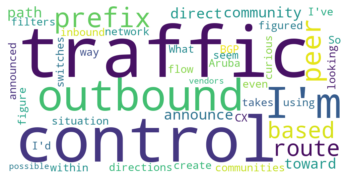

In [36]:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [37]:
#wordcloud for sysadmin subreddit
sysadmin_wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(sysadmin_final_df['selftext'][0])

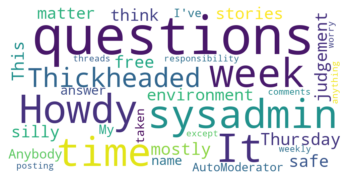

In [38]:
plt.figure()
plt.imshow(sysadmin_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

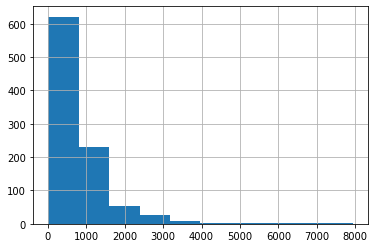

In [39]:
#number of characters present in each sentence of the subreddit sysadmin
sysadmin_final_df['selftext'].str.len().hist()

In [40]:
#average character count for subreddit sysadmin 
#word count might be more informative
sysadmin_final_df['selftext'].str.len().mean()

830.2760800842992

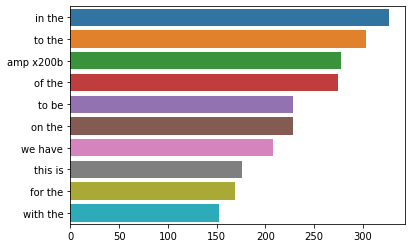

In [41]:
#top 10 ngrams for subreddit sysadmin
top_n_bigrams=get_top_ngram(sysadmin_final_df['selftext'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

In [42]:
#wordcloud for networking subreddit
networking_wordcloud = WordCloud(width=1000, height=500, 
                                 background_color="white").generate(networking_final_df['selftext'][0])

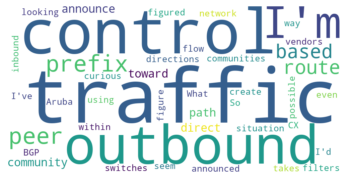

In [43]:
plt.figure()
plt.imshow(networking_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

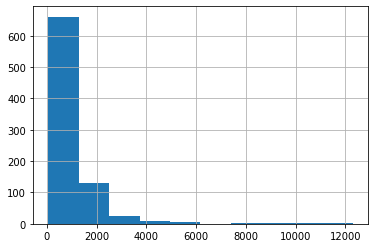

In [44]:
#number of characters present in each sentence of the subreddit networking
networking_final_df['selftext'].str.len().hist()

In [45]:
#average character count for subreddit networking 
#word count might be more informative
networking_final_df['selftext'].str.len().mean()

967.3465227817745

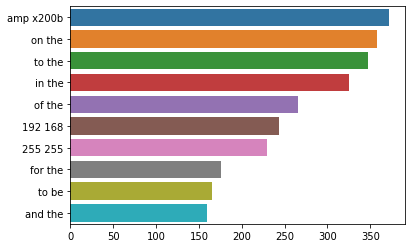

In [46]:
#top 10 ngrams for subreddit networking
top_n_bigrams=get_top_ngram(networking_final_df['selftext'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

## CountVectorizer

In [51]:
vectorizer = CountVectorizer(analyzer= 'word',
                             tokenizer= None,
                             preprocessor= None,
                             stop_words = None)

In [52]:
#max features - https://stackoverflow.com/questions/46118910/scikit-learn-vectorizer-max-features 

In [53]:
train_data_features = vectorizer.fit_transform(clean_train_posts)
test_data_features = vectorizer.transform(clean_test_posts)

In [54]:
print(train_data_features.shape)

(1426, 10141)


In [55]:
print(test_data_features.shape)

(357, 10141)


In [56]:
vocab = vectorizer.get_feature_names()
print(vocab)

['aaaa', 'aad', 'ab', 'abandon', 'abandoned', 'abc', 'abgn', 'abh', 'ability', 'abit', 'able', 'abnormal', 'abondoned', 'abroad', 'abruptly', 'absence', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbing', 'abstract', 'ac', 'academic', 'accelerating', 'acceleration', 'accelerator', 'accent', 'accentcolormenu', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'access', 'accessable', 'accessed', 'accessibility', 'accessible', 'accessing', 'accidental', 'accidentally', 'accidentially', 'accommodating', 'accompanying', 'accomplish', 'accomplishing', 'according', 'accordingly', 'account', 'accountability', 'accountant', 'accountid', 'accounting', 'accredited', 'accross', 'accumulate', 'accumulated', 'accuracy', 'accurate', 'ace', 'achieve', 'achieved', 'achieves', 'aci', 'ack', 'acked', 'ackes', 'acknowledgement', 'acks', 'acl', 'acls', 'acm', 'acquainted', 'acquire', 'acquired', 'acquires', 'acquiring', 'acquisition', 'acrobat', 'acrobatetk', 'acroexch', 'acronis', 'a

In [57]:
X_train_cvec = pd.DataFrame(train_data_features.toarray(), columns=vectorizer.get_feature_names())
X_train_cvec.head()

,aaaa,aad,ab,abandon,abandoned,abc,abgn,abh,ability,abit,able,abnormal,abondoned,abroad,abruptly,absence,absolute,absolutely,absorb,absorbed,absorbing,abstract,ac,academic,accelerating,acceleration,accelerator,accent,accentcolormenu,accept,acceptable,acceptance,accepted,accepting,access,accessable,accessed,accessibility,accessible,accessing,accidental,accidentally,accidentially,accommodating,accompanying,accomplish,accomplishing,according,accordingly,account,accountability,accountant,accountid,accounting,accredited,accross,accumulate,accumulated,accuracy,accurate,ace,achieve,achieved,achieves,aci,ack,acked,ackes,acknowledgement,acks,acl,acls,acm,acquainted,acquire,acquired,acquires,acquiring,acquisition,acrobat,acrobatetk,acroexch,acronis,acronym,across,act,acting,action,activate,activated,activation,active,actively,activesync,activex,activity,actual,actuality,actually,acunetix,ad,adac,adafef,adam,adamant,adapter,adblock,adblocker,add,added,adder,adding,addition,additional,additionaldomain,additionally,additoinal,addled,addons,addr,addresa,address,addressed,addressing,addsvlantonni,adequate,adfee,adfs,adhd,adi,adjacency,adjust,adjustable,adjusted,adjusting,adminguide,administer,administered,administration,administrative,administrator,admins,admit,admittedly,admx,adobe,adopted,adp,adress,adrian,adrs,adsl,adsm,aduc,adva,advance,advanced,advancement,advancing,advantage,advantageous,adventerprisek,adversary,advertise,advertised,advertisement,advertises,advertising,advertsied,advice,advise,advises,advising,advisor,advisory,ae,aepocomputerproperties,aepoleafnode,aepoprodpropsview,aer,aes,af,afa,afaik,afe,affect,affected,affecting,affiliated,affinity,afford,affordable,afforded,afloat,aforementioned,afraid,africa,aftermarket,afternoon,afterwards,age,aged,agency,agent,agg,aggravating,aggregate,aggregation,aggregator,aggressive,aggressively,agile,aging,ago,agree,agreed,agreeing,agreement,ahead,ahv,ahve,ai,aia,aim,air,airbnb,airfiber,airfiberx,airflow,airmagnet,aironets,airport,aisle,aita,aja,ak,aka,akin,akips,akorn,al,alarm,alb,albeit,alcatel,alert,alerting,alexma,alg,algorithm,...,winre,winrm,winserver,winsock,winstations,wipe,wiped,wiping,wips,wire,wired,wireguard,wireless,wireshark,wiring,wisdom,wise,wiser,wish,wished,wishing,wisp,wit,witcher,within,without,withstand,withstanding,witnessing,wizard,wizardry,wl,wlc,wm,wmi,wmic,wmp,wmware,woefully,wog,woke,wol,wonder,wondered,wonderful,wondering,wont,woq,word,worded,wording,wordpress,wordy,work,workaround,workarounds,workbook,worked,worker,workflow,workfolders,workforce,workgroup,working,workload,workmail,workout,workplace,worksheet,workshop,workspace,workstation,workvpn,world,worldwide,worried,worry,worrying,worse,worst,worth,worthless,worthwhile,would,wouldnt,wow,wowza,wp,wpa,wpad,wpaddecision,wpaddecisionreason,wpaddetectedurl,wqkfzvefrbfvndqprnhdeqvlevlfrs,wrap,wrapped,wrapper,wrapping,wreddrops,wrench,write,writer,writes,writing,written,wrong,wrongly,wrote,wscale,wscript,wshshell,wsus,wt,wtf,wtp,wundertech,wvd,wwtizujql,www,wwwrl,wwwui,wy,xa,xafe,xauth,xb,xc,xca,xcp,xczajbgnvbagtak,xd,xe,xecf,xen,xeon,xerox,xffff,xg,xgigabit,xics,xive,xjckqphc,xjxq,xl,xllucjkpaihkbjdod,xlsc,xlsx,xmit,xml,xmlns,xmsgtask,xn,xnm,xoaxvnu,xot,xp,xport,xprotect,xqyqxb,xr,xserver,xt,xtm,xvy,xx,xxx,xxxnameherexxx,xxxx,xxxxnameherexxxx,xxxxx,xxxxxx,xxxxxxxxx,xyz,ya,yada,yah,yahoo,yaml,yanked,yar,yard,ybfd,yc,yea,yeah,year,yearly,yechhhh,yeet,yekkxtkrbeen,yellow,yes,yesterday,yet,yield,yielded,yikes,yk,ykbebj,yml,ymo,ynripyvd,york,young,youtu,youtube,yr,ytou,ytti,yudgblpxnhhdekfkqmdovkjbz,yueq,yum,yvph,yvywg,yy,yyy,zabbix,zaeyydqpxam,zayo,zb,zdnet,zdump,zemwkd,zenitel,zentyal,zero,zficvo,zfs,zgdounfttzhbmxbfytlmowljtgrjymlvavflbtrmuvk,zi,zipper,zix,zl,zlyeluk,zohopublic,zone,zonedirector,zoneset,zonk,zoom,zp,zscaler,ztp,ztv,zurich,zxvhpnb,zyrnkvm,zytklktelvb,zywall,zyxel
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [58]:
X_train_cvec.to_csv('../datasets/train.csv')

In [59]:
X_test_cvec = pd.DataFrame(test_data_features.toarray(), columns=vectorizer.get_feature_names())
X_test_cvec.head()

,aaaa,aad,ab,abandon,abandoned,abc,abgn,abh,ability,abit,able,abnormal,abondoned,abroad,abruptly,absence,absolute,absolutely,absorb,absorbed,absorbing,abstract,ac,academic,accelerating,acceleration,accelerator,accent,accentcolormenu,accept,acceptable,acceptance,accepted,accepting,access,accessable,accessed,accessibility,accessible,accessing,accidental,accidentally,accidentially,accommodating,accompanying,accomplish,accomplishing,according,accordingly,account,accountability,accountant,accountid,accounting,accredited,accross,accumulate,accumulated,accuracy,accurate,ace,achieve,achieved,achieves,aci,ack,acked,ackes,acknowledgement,acks,acl,acls,acm,acquainted,acquire,acquired,acquires,acquiring,acquisition,acrobat,acrobatetk,acroexch,acronis,acronym,across,act,acting,action,activate,activated,activation,active,actively,activesync,activex,activity,actual,actuality,actually,acunetix,ad,adac,adafef,adam,adamant,adapter,adblock,adblocker,add,added,adder,adding,addition,additional,additionaldomain,additionally,additoinal,addled,addons,addr,addresa,address,addressed,addressing,addsvlantonni,adequate,adfee,adfs,adhd,adi,adjacency,adjust,adjustable,adjusted,adjusting,adminguide,administer,administered,administration,administrative,administrator,admins,admit,admittedly,admx,adobe,adopted,adp,adress,adrian,adrs,adsl,adsm,aduc,adva,advance,advanced,advancement,advancing,advantage,advantageous,adventerprisek,adversary,advertise,advertised,advertisement,advertises,advertising,advertsied,advice,advise,advises,advising,advisor,advisory,ae,aepocomputerproperties,aepoleafnode,aepoprodpropsview,aer,aes,af,afa,afaik,afe,affect,affected,affecting,affiliated,affinity,afford,affordable,afforded,afloat,aforementioned,afraid,africa,aftermarket,afternoon,afterwards,age,aged,agency,agent,agg,aggravating,aggregate,aggregation,aggregator,aggressive,aggressively,agile,aging,ago,agree,agreed,agreeing,agreement,ahead,ahv,ahve,ai,aia,aim,air,airbnb,airfiber,airfiberx,airflow,airmagnet,aironets,airport,aisle,aita,aja,ak,aka,akin,akips,akorn,al,alarm,alb,albeit,alcatel,alert,alerting,alexma,alg,algorithm,...,winre,winrm,winserver,winsock,winstations,wipe,wiped,wiping,wips,wire,wired,wireguard,wireless,wireshark,wiring,wisdom,wise,wiser,wish,wished,wishing,wisp,wit,witcher,within,without,withstand,withstanding,witnessing,wizard,wizardry,wl,wlc,wm,wmi,wmic,wmp,wmware,woefully,wog,woke,wol,wonder,wondered,wonderful,wondering,wont,woq,word,worded,wording,wordpress,wordy,work,workaround,workarounds,workbook,worked,worker,workflow,workfolders,workforce,workgroup,working,workload,workmail,workout,workplace,worksheet,workshop,workspace,workstation,workvpn,world,worldwide,worried,worry,worrying,worse,worst,worth,worthless,worthwhile,would,wouldnt,wow,wowza,wp,wpa,wpad,wpaddecision,wpaddecisionreason,wpaddetectedurl,wqkfzvefrbfvndqprnhdeqvlevlfrs,wrap,wrapped,wrapper,wrapping,wreddrops,wrench,write,writer,writes,writing,written,wrong,wrongly,wrote,wscale,wscript,wshshell,wsus,wt,wtf,wtp,wundertech,wvd,wwtizujql,www,wwwrl,wwwui,wy,xa,xafe,xauth,xb,xc,xca,xcp,xczajbgnvbagtak,xd,xe,xecf,xen,xeon,xerox,xffff,xg,xgigabit,xics,xive,xjckqphc,xjxq,xl,xllucjkpaihkbjdod,xlsc,xlsx,xmit,xml,xmlns,xmsgtask,xn,xnm,xoaxvnu,xot,xp,xport,xprotect,xqyqxb,xr,xserver,xt,xtm,xvy,xx,xxx,xxxnameherexxx,xxxx,xxxxnameherexxxx,xxxxx,xxxxxx,xxxxxxxxx,xyz,ya,yada,yah,yahoo,yaml,yanked,yar,yard,ybfd,yc,yea,yeah,year,yearly,yechhhh,yeet,yekkxtkrbeen,yellow,yes,yesterday,yet,yield,yielded,yikes,yk,ykbebj,yml,ymo,ynripyvd,york,young,youtu,youtube,yr,ytou,ytti,yudgblpxnhhdekfkqmdovkjbz,yueq,yum,yvph,yvywg,yy,yyy,zabbix,zaeyydqpxam,zayo,zb,zdnet,zdump,zemwkd,zenitel,zentyal,zero,zficvo,zfs,zgdounfttzhbmxbfytlmowljtgrjymlvavflbtrmuvk,zi,zipper,zix,zl,zlyeluk,zohopublic,zone,zonedirector,zoneset,zonk,zoom,zp,zscaler,ztp,ztv,zurich,zxvhpnb,zyrnkvm,zytklktelvb,zywall,zyxel
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [60]:
X_train_cvec.shape

(1426, 10141)

## Naive Bayes

Choosing MultinomialNB since the features are all integer counts, confirmed from EDA that we cannot use GaussianNB since the features are not normally distributed.

In [61]:
nb = MultinomialNB()

In [62]:
model = nb.fit(X_train_cvec, y_train)
nb.score(X_train_cvec, y_train)

0.9495091164095372

In [63]:
accuracy = cross_val_score(nb, X_test_cvec, y_test, scoring='accuracy', cv=10)
accuracy

array([0.72222222, 0.80555556, 0.77777778, 0.88888889, 0.91666667,
       0.80555556, 0.86111111, 0.71428571, 0.8       , 0.88571429])

In [64]:
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

Accuracy of Model with Cross Validation is: 81.77777777777777


In [65]:
nb.score(X_test_cvec, y_test)

0.8823529411764706

In [66]:
nb_predictions = nb.predict(X_test_cvec)

In [67]:
confusion_matrix(y_test, nb_predictions)

array([[139,  28],
       [ 14, 176]])

In [68]:
tn, fp, fn, tp = confusion_matrix(y_test, nb_predictions).ravel()

In [69]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 139
False Positives: 28
False Negatives: 14
True Positives: 176


In [70]:
#draw ROC curve for naive bayes if possible
#https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
#pred_proba = [i[1] for i in nb.predict_proba(X_test)]

#pred_df = pd.DataFrame({'true_values': y_test,'pred_probs': pred_proba})

## Trying out TfidVectorizer
https://www.quora.com/What-is-the-difference-between-TfidfVectorizer-and-CountVectorizer-1

## Gridsearch CV and Pipeline

https://towardsdatascience.com/nlp-with-pipeline-gridsearch-5922266e82f4

In [71]:
#setting up Naive Bayes
tvc_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mb', MultinomialNB())
])

#setting up the random forest
rf_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])


#fit
tvc_pipe.fit(clean_train_posts, y_train)
rf_pipe.fit(clean_train_posts, y_train)
#log_pipe.fit(clean_train_posts, y_train)

#setting params for TFIDF Vectorizer gridsearch
tf_params = {
    'tvec__ngram_range': [(1,1), (1,2), (2,2)],
    'tvec__min_df': [2,3],
    'tvec__max_df': [0.9, 0.95],
}

#setting up randomforest params
rf_params = {
    'tvec__max_features': [2000],
    'tvec__ngram_range': [(1,1), (1,2), (2,2)],
    'tvec__min_df': [2,3],
    'tvec__max_df': [0.9, 0.95],
    'rf__max_depth': [1000],
    'rf__min_samples_split': [100],
    'rf__max_leaf_nodes': [None]
}


# Setting up GridSearch for Randomforest
rf_gs = GridSearchCV(rf_pipe, param_grid=rf_params, cv = 10, verbose = 1, n_jobs = -1)
# Setting up GridSearch for Naive Bayes
tvc_gs = GridSearchCV(tvc_pipe, param_grid=tf_params, cv = 10, verbose =1, n_jobs = -1)


# Fitting Randomforest CV GS
rf_gs.fit(clean_train_posts, y_train)
# Fitting TVC GS
tvc_gs.fit(clean_train_posts, y_train)


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   13.0s finished


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.8s
/Users/johnsmith/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    5.9s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [72]:
# Scoring Training data on TFIDFVectorizer, Naive Bayes
print(tvc_gs.score(clean_train_posts, y_train))
print(tvc_gs.best_estimator_)

0.9298737727910238
Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.9, max_features=None,
                                 min_df=3, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('mb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)


In [73]:
pd.DataFrame(tvc_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tvec__max_df,param_tvec__min_df,param_tvec__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.082700,0.005606,0.011452,0.002421,0.9,2,"(1, 1)","{'tvec__max_df': 0.9, 'tvec__min_df': 2, 'tvec...",0.860140,0.853147,0.839161,0.797203,0.846154,0.832168,0.816901,0.880282,0.845070,0.859155,0.842938,0.022299,5
1,0.377939,0.024665,0.023039,0.006038,0.9,2,"(1, 2)","{'tvec__max_df': 0.9, 'tvec__min_df': 2, 'tvec...",0.853147,0.832168,0.825175,0.776224,0.846154,0.832168,0.802817,0.880282,0.838028,0.873239,0.835940,0.029274,7
2,0.291366,0.021563,0.011658,0.001086,0.9,2,"(2, 2)","{'tvec__max_df': 0.9, 'tvec__min_df': 2, 'tvec...",0.769231,0.748252,0.762238,0.685315,0.769231,0.762238,0.774648,0.774648,0.767606,0.802817,0.761622,0.028619,9
3,0.083382,0.004182,0.009268,0.000613,0.9,3,"(1, 1)","{'tvec__max_df': 0.9, 'tvec__min_df': 3, 'tvec...",0.839161,0.860140,0.839161,0.811189,0.846154,0.832168,0.838028,0.887324,0.852113,0.866197,0.847163,0.019747,1
4,0.357115,0.019815,0.017718,0.002890,0.9,3,"(1, 2)","{'tvec__max_df': 0.9, 'tvec__min_df': 3, 'tvec...",0.846154,0.853147,0.825175,0.783217,0.853147,0.846154,0.809859,0.880282,0.852113,0.880282,0.842953,0.028423,3
5,0.280299,0.013285,0.011493,0.001261,0.9,3,"(2, 2)","{'tvec__max_df': 0.9, 'tvec__min_df': 3, 'tvec...",0.748252,0.720280,0.720280,0.692308,0.720280,0.741259,0.739437,0.774648,0.711268,0.760563,0.732857,0.023345,11
6,0.086007,0.004325,0.009798,0.000981,0.95,2,"(1, 1)","{'tvec__max_df': 0.95, 'tvec__min_df': 2, 'tve...",0.860140,0.853147,0.839161,0.797203,0.846154,0.832168,0.816901,0.880282,0.845070,0.859155,0.842938,0.022299,5
7,0.369175,0.026175,0.018607,0.003744,0.95,2,"(1, 2)","{'tvec__max_df': 0.95, 'tvec__min_df': 2, 'tve...",0.853147,0.832168,0.825175,0.776224,0.846154,0.832168,0.802817,0.880282,0.838028,0.873239,0.835940,0.029274,7
8,0.310847,0.019844,0.013122,0.002311,0.95,2,"(2, 2)","{'tvec__max_df': 0.95, 'tvec__min_df': 2, 'tve...",0.769231,0.748252,0.762238,0.685315,0.769231,0.762238,0.774648,0.774648,0.767606,0.802817,0.761622,0.028619,9
9,0.092858,0.011246,0.009767,0.002221,0.95,3,"(1, 1)","{'tvec__max_df': 0.95, 'tvec__min_df': 3, 'tve...",0.839161,0.860140,0.839161,0.811189,0.846154,0.832168,0.838028,0.887324,0.852113,0.866197,0.847163,0.019747,1


In [74]:
# Scoring Test data on TFIDFVectorizer, Naive Bayes
tvc_gs.score(clean_test_posts, y_test)

0.8487394957983193

In [75]:
# Scoring Training data on TFIDFVectorizer, RandomForest
print(rf_gs.score(clean_train_posts, y_train))
print(rf_gs.best_params_)
print(rf_gs.best_estimator_)

0.9551192145862553
{'rf__max_depth': 1000, 'rf__max_leaf_nodes': None, 'rf__min_samples_split': 100, 'tvec__max_df': 0.9, 'tvec__max_features': 2000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 1)}
Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.9, max_features=2000,
                                 min_df=3, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                 

In [76]:
pd.DataFrame(rf_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_depth,param_rf__max_leaf_nodes,param_rf__min_samples_split,param_tvec__max_df,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.383547,0.008096,0.017834,0.001320,1000,None,100,0.9,2000,2,"(1, 1)","{'rf__max_depth': 1000, 'rf__max_leaf_nodes': ...",0.832168,0.839161,0.811189,0.748252,0.825175,0.825175,0.852113,0.852113,0.866197,0.887324,0.833887,0.035489,4
1,0.646290,0.011514,0.024428,0.001971,1000,None,100,0.9,2000,2,"(1, 2)","{'rf__max_depth': 1000, 'rf__max_leaf_nodes': ...",0.867133,0.825175,0.818182,0.748252,0.832168,0.825175,0.845070,0.838028,0.845070,0.887324,0.833158,0.034580,5
2,0.585013,0.007382,0.023694,0.001429,1000,None,100,0.9,2000,2,"(2, 2)","{'rf__max_depth': 1000, 'rf__max_leaf_nodes': ...",0.664336,0.685315,0.720280,0.692308,0.720280,0.643357,0.669014,0.767606,0.647887,0.739437,0.694982,0.038894,9
3,0.375306,0.005720,0.017955,0.001897,1000,None,100,0.9,2000,3,"(1, 1)","{'rf__max_depth': 1000, 'rf__max_leaf_nodes': ...",0.853147,0.846154,0.797203,0.748252,0.839161,0.818182,0.852113,0.830986,0.880282,0.894366,0.835984,0.039474,1
4,0.670048,0.007289,0.023901,0.001448,1000,None,100,0.9,2000,3,"(1, 2)","{'rf__max_depth': 1000, 'rf__max_leaf_nodes': ...",0.846154,0.839161,0.818182,0.755245,0.811189,0.811189,0.852113,0.866197,0.838028,0.859155,0.829661,0.030811,7
5,0.601657,0.012151,0.026180,0.002248,1000,None,100,0.9,2000,3,"(2, 2)","{'rf__max_depth': 1000, 'rf__max_leaf_nodes': ...",0.636364,0.657343,0.671329,0.643357,0.713287,0.657343,0.690141,0.725352,0.626761,0.739437,0.676071,0.037188,12
6,0.384521,0.006322,0.019556,0.004259,1000,None,100,0.95,2000,2,"(1, 1)","{'rf__max_depth': 1000, 'rf__max_leaf_nodes': ...",0.846154,0.860140,0.804196,0.755245,0.825175,0.811189,0.845070,0.838028,0.873239,0.894366,0.835280,0.037183,2
7,0.755995,0.064011,0.028936,0.003985,1000,None,100,0.95,2000,2,"(1, 2)","{'rf__max_depth': 1000, 'rf__max_leaf_nodes': ...",0.853147,0.825175,0.804196,0.734266,0.832168,0.832168,0.838028,0.852113,0.845070,0.894366,0.831070,0.039130,6
8,0.683657,0.049854,0.029727,0.008250,1000,None,100,0.95,2000,2,"(2, 2)","{'rf__max_depth': 1000, 'rf__max_leaf_nodes': ...",0.650350,0.699301,0.720280,0.692308,0.720280,0.636364,0.669014,0.732394,0.669014,0.753521,0.694282,0.035922,10
9,0.416680,0.036407,0.017020,0.000976,1000,None,100,0.95,2000,3,"(1, 1)","{'rf__max_depth': 1000, 'rf__max_leaf_nodes': ...",0.853147,0.839161,0.825175,0.755245,0.832168,0.818182,0.830986,0.845070,0.866197,0.880282,0.834561,0.031991,3


In [77]:
# Checking Test score on TFIDFVectorizer, RandomForest
rf_gs.score(clean_test_posts, y_test)

0.8179271708683473

In [78]:
tvc_gs.predict(clean_test_posts)

array([0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,

In [79]:
rf_pipe.steps[1][1].feature_importances_

array([0.00000000e+00, 4.75298723e-05, 2.74757889e-05, ...,
       0.00000000e+00, 0.00000000e+00, 8.95958807e-05])

In [80]:
rf_pipe.steps[1][1].predict_proba

<bound method ForestClassifier.predict_proba of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

In [81]:
#top random forest features in descending order of importance
tvc_title = pd.DataFrame(rf_pipe.steps[1][1].feature_importances_, 
                         tvc_pipe.steps[0][1].get_feature_names(), columns=['importance'])
tvc_title.sort_values('importance', ascending = False).head(10)

,importance
cisco,0.024207
switch,0.021320
ip,0.010861
window,0.010457
traffic,0.009992
router,0.009221
port,0.008912
packet,0.008447
vlan,0.007396
email,0.007347


In [82]:
#least important features and see if it is 'stop words' worthy
tvc_title.sort_values('importance', ascending = True).head(10)

,importance
aaaa,0.0
netware,0.0
netsuite,0.0
netsol,0.0
netsh,0.0
netscaler,0.0
netowork,0.0
netmanias,0.0
netlogon,0.0
netlog,0.0


## Logistic Regression with TFID

In [83]:
#setting up logistic regression
log_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

#fit
log_pipe.fit(clean_train_posts, y_train)

#setting up logistic regression params
log_params = {
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [1, 5, 10],
    'lr__max_iter': [20, 50, 100],
    'tvec__min_df': [2,3],
    'tvec__max_df': [0.9, 0.95],
}

# Setting up Gridsearch for logistic regression
log_gs = GridSearchCV(log_pipe, param_grid=log_params, cv = 10, verbose =1, n_jobs = -1)

# fitting logistic regression GS
log_gs.fit(clean_train_posts, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
/Users/johnsmith/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   14.3s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [84]:
# Scoring Training data on TFIDFVectorizer, logistic regression
print(log_gs.score(clean_train_posts, y_train))
print(log_gs.best_params_)
print(log_gs.best_estimator_)

0.9438990182328191
{'lr__C': 1, 'lr__max_iter': 20, 'lr__penalty': 'l2', 'tvec__max_df': 0.9, 'tvec__min_df': 2}
Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.9, max_features=None,
                                 min_df=2, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(

In [85]:
# Checking Test score on TFIDFVectorizer, logistic regression
log_gs.score(clean_test_posts, y_test)

0.8543417366946778

## Logistic Regression with CountVectorizer

In [86]:
logreg = LogisticRegression()

In [87]:
logreg.fit(X_train_cvec, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [88]:
logreg.score(X_train_cvec, y_train)

0.9992987377279102

In [89]:
accuracy = cross_val_score(logreg, X_test_cvec, y_test, scoring='accuracy', cv=10)
accuracy

array([0.80555556, 0.72222222, 0.80555556, 0.86111111, 0.83333333,
       0.75      , 0.88888889, 0.8       , 0.82857143, 0.82857143])

In [90]:
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

Accuracy of Model with Cross Validation is: 81.23809523809523


In [91]:
logreg_predictions = logreg.predict(X_test_cvec)

In [92]:
confusion_matrix(y_test, logreg_predictions)

array([[129,  38],
       [ 18, 172]])

In [93]:
logreg.score(X_test_cvec, y_test)

0.8431372549019608